## Barcelona Point Data to LineString Data:

The Barca open data set linked below contains lots of interesting stuff to explore. As I keep playing with this I'm realizing that the many bits of learning are getting jumbled and need some new structure. This notebook is just focused on how to import, filter, and plot a .csv file (the Barca street data specifically). Reading and plotting .shp files and .geojson files are in separate notebooks.

[BCN Open Data (Trams - carrer):](https://opendata-ajuntament.barcelona.cat/data/en/dataset/mapa-graf-viari-carrers-wms)

[Geopandas Reference:](https://geopandas.org/en/stable/index.html)

[Barca Street Mapping:](https://diegoquintanav.github.io/folium-barcelona-EN.html) This github  page describes taking .csv data and transforming that point data into Shapely LineStrings that can be plotted. Along the way I am clearly going to develop some experience with manipulating pandas data frames:)

titanic.iloc[9:25, 2:5]

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
import geoplot as gp
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
from IPython.display import display, Image
from shapely.geometry import Point, LineString

### Reading the .csv data:

Pandas originally had difficulty decoding some of the characters. When I opened the .csv file in Libre these characters may be the ones that showed as unreadable. Resaving the file from Libre and reading it in embeds these error characters with no issues. Interesting data science question I suspect. 

#### Encoding Issues:

As I got deeper into this project I found there were a lot of encoding errors that made searching and labeling frustrating. After some thought I went back and reopened the original trams.csv file using 'Latin 3' encoding and Catalan as the language. This seemed to produce a file with no obvious errors in reading cells. Then there was a problem using pd.read_csv which uses a utf-8 default encoding. This question came up on [a stackexchange post](https://datascience.stackexchange.com/questions/12343/pandas-read-csv-with-spanish-characters)  and a suggestion that seemed consistent was to define the pandas read_csv edcoding as 'latin-1' (I tried 'latin-3' to match the orginal file read encoding in Libre office but that doesn't exist). Using this encoding made pandas happy -- we'll see if it resolves most of the issues. 

[List of Encodings;](https://docs.python.org/3/library/codecs.html#standard-encodings)

So -- the above steps resolved (I think) the encoding issues for the street names in the .csv file but they introduced some unpredicatable errors in the encoding for the coordinates. This led to unplotable points on the street lines that were produced. Now I need to figure out if I can manage the encoding for numbers separately from characters or encode single columns.

**Current Status:** If I open the .csv file with 'latin 3' character set and English encodings it seems that it doesn't screw up the coordinates and reads the street names well enough. Because I can't type the 'latin' characters there are some limitations to my ability to manually slice the data frame but pershaps that won't be a problem.

In [7]:
streets = pd.read_csv("bcn-geodata/BCN_GrafVial_CSV/BCN_Trams2.csv", sep=",", encoding='latin-1')
streets.head(10)

,FID,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,...,TVia_D,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq
0,0,432128.893,4581047.606,42.615,15.04,T00001B,N00001D,N00002E,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,2,1,Ciutat Vella,10410,10900,Carrer,Carrer Pepe Rubianes,1
1,1,432156.649,4581054.946,14.806,14.20,T00002C,N00002E,N00003F,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5
2,2,432171.171,4581059.200,15.480,18.40,T00003D,N00003F,N00004G,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5
3,3,432185.863,4581063.068,14.969,10.98,T00004E,N00004G,N00005H,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,8 <=> 8 Z,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9
4,4,432200.396,4581066.659,15.010,16.80,T00005F,N00005H,N00006I,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,10,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9
5,5,432214.836,4581070.635,14.953,14.00,T00006G,N00006I,N00007J,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,12 <=> 14,1,Ciutat Vella,10461,10900,Carrer,Carrer Pepe Rubianes,11 <=> 13
6,6,432229.274,4581074.508,14.949,16.00,T00007H,N00007J,N00008K,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,12 <=> 14,1,Ciutat Vella,10461,10900,Carrer,Carrer Pepe Rubianes,11 <=> 13
7,7,432243.459,4581078.413,14.477,14.70,T00008I,N00008K,N00009L,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,16,1,Ciutat Vella,10480,10900,Carrer,Carrer Pepe Rubianes,15 - 17
8,8,432257.772,4581082.416,15.252,16.50,T00009J,N00009L,N00010E,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,18,1,Ciutat Vella,10480,10900,Carrer,Carrer Pepe Rubianes,15 - 17
9,9,432272.244,4581086.671,14.916,16.30,T00010C,N00010E,N00011F,1,Ciutat Vella,...,Carrer,Carrer Pepe Rubianes,20,1,Ciutat Vella,10490,10900,Carrer,Carrer Pepe Rubianes,19 - 21


### From Pandas to Geopandas

The .csv file is read in as a pandas data frame. For mapping purposes it needs to be converted to a geopandas data frame which basically involves reading the x and y coordinate columns and converting them to shapely Points in a colum named geometry. The new columm is at the end of the data frame.

### Converting the coordinates to pairs:

This method from the [Geopandas manual](https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html) did a great job of converting the
```python
tramsFull = gpd.GeoDataFrame(streets, geometry = gpd.points_from_xy(streets.COORD_X,streets.COORD_Y))
tramsFull
```
While I am frustrated that the geometry column is at the end of the frame I am loathe to reorganize the dataframe arbitrarily. For now I will keep it though it is clear from the [pandas indexing method](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html) that I could swap data columns around for my convenience if needed.

In [8]:
tramsFull = gpd.GeoDataFrame(streets, geometry = gpd.points_from_xy(streets.COORD_X,streets.COORD_Y))
tramsFull

,FID,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,...,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq,geometry
0,0,432128.893,4581047.606,42.615,15.04,T00001B,N00001D,N00002E,1,Ciutat Vella,...,Carrer Pepe Rubianes,2,1,Ciutat Vella,10410,10900,Carrer,Carrer Pepe Rubianes,1,POINT (432128.893 4581047.606)
1,1,432156.649,4581054.946,14.806,14.20,T00002C,N00002E,N00003F,1,Ciutat Vella,...,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5,POINT (432156.649 4581054.946)
2,2,432171.171,4581059.200,15.480,18.40,T00003D,N00003F,N00004G,1,Ciutat Vella,...,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5,POINT (432171.171 4581059.200)
3,3,432185.863,4581063.068,14.969,10.98,T00004E,N00004G,N00005H,1,Ciutat Vella,...,Carrer Pepe Rubianes,8 <=> 8 Z,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9,POINT (432185.863 4581063.068)
4,4,432200.396,4581066.659,15.010,16.80,T00005F,N00005H,N00006I,1,Ciutat Vella,...,Carrer Pepe Rubianes,10,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9,POINT (432200.396 4581066.659)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14826,14826,426840.231,4583372.122,37.131,306.71,T21653T,N07106N,N10755R,5,Sarrià-Sant Gervasi,...,Via Augusta,313,5,Sarrià-Sant Gervasi,34491,28000,Via,Via Augusta,313,POINT (426840.231 4583372.122)
14827,14827,426952.780,4583228.384,133.414,312.34,T21654U,N10463I,N10519H,5,Sarrià-Sant Gervasi,...,Carrer Cardenal Sentmenat,2 - 6,5,Sarrià-Sant Gervasi,34421,65301,Carrer,Carrer Cardenal Sentmenat,1 - 5,POINT (426952.780 4583228.384)
14828,14828,433594.464,4583025.419,119.651,314.89,T21656W,N11406D,N08604E,10,Sant Martí,...,Carrer Llacuna,2,10,Sant Martí,5989,183603,Carrer,Carrer Llacuna,1,POINT (433594.464 4583025.419)
14829,14829,433492.108,4582841.885,404.104,45.14,T21657X,N08591Q,N11406D,10,Sant Martí,...,,0,10,Sant Martí,5989,700662,Carrer,Carrer Salvador Espriu,97 <=> 99 - 109,POINT (433492.108 4582841.885)


### Smaller Subset of Frame

In [11]:
tramsSmall = tramsFull.iloc[0:1000,:]
tramsSmall                 

,FID,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,...,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq,geometry
0,0,432128.893,4581047.606,42.615,15.04,T00001B,N00001D,N00002E,1,Ciutat Vella,...,Carrer Pepe Rubianes,2,1,Ciutat Vella,10410,10900,Carrer,Carrer Pepe Rubianes,1,POINT (432128.893 4581047.606)
1,1,432156.649,4581054.946,14.806,14.20,T00002C,N00002E,N00003F,1,Ciutat Vella,...,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5,POINT (432156.649 4581054.946)
2,2,432171.171,4581059.200,15.480,18.40,T00003D,N00003F,N00004G,1,Ciutat Vella,...,Carrer Pepe Rubianes,4 <=> 6,1,Ciutat Vella,10421,10900,Carrer,Carrer Pepe Rubianes,3 <=> 5,POINT (432171.171 4581059.200)
3,3,432185.863,4581063.068,14.969,10.98,T00004E,N00004G,N00005H,1,Ciutat Vella,...,Carrer Pepe Rubianes,8 <=> 8 Z,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9,POINT (432185.863 4581063.068)
4,4,432200.396,4581066.659,15.010,16.80,T00005F,N00005H,N00006I,1,Ciutat Vella,...,Carrer Pepe Rubianes,10,1,Ciutat Vella,10441,10900,Carrer,Carrer Pepe Rubianes,7 <=> 9,POINT (432200.396 4581066.659)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,431137.670,4581575.002,51.016,-36.00,T01495N,N01005L,N01006M,1,Ciutat Vella,...,Carrer Sant Honorat,10,1,Ciutat Vella,12830,303104,Carrer,Carrer Sant Honorat,1 <=> 3,POINT (431137.670 4581575.002)
996,996,431096.783,4581613.844,62.510,-44.00,T01496O,N01006M,N01007N,1,Ciutat Vella,...,Carrer Sant Honorat,10,1,Ciutat Vella,12790,303104,Carrer,Carrer Sant Honorat,5 <=> 13,POINT (431096.783 4581613.844)
997,997,431153.476,4581620.986,88.282,318.68,T01497P,N01008O,N00662I,1,Ciutat Vella,...,Carrer Bisbe,2 <=> 8 - 4,1,Ciutat Vella,12780,232505,Carrer,Carrer Bisbe,1,POINT (431153.476 4581620.986)
998,998,431008.148,4581585.186,44.483,19.70,T01498Q,N00985Y,N01009P,1,Ciutat Vella,...,Baixada Santa Eulàlia,2 <=> 4,1,Ciutat Vella,12771,315205,Baixada,Baixada Santa Eulàlia,1 <=> 3,POINT (431008.148 4581585.186)


In [16]:
uniqueTrams = tramsSmall['NVia_D'].unique()
print('Unique elements in column "NVia_D" ', len(uniqueTrams))
print(uniqueTrams[10:20])

Unique elements in column "NVia_D"  376
['Carrer Sevilla' 'Carrer Baluard' 'Carrer Mestrança' 'Carrer Meer'
 'Carrer Pontevedra' 'Carrer Atlàntida' 'Carrer Grau i Torras'
 'Carrer Guitert' 'Carrer Vila Joiosa' 'Carrer Sant Carles']


### Mini Data Frame for 1 Street

As a test case I have pulled the rows from the pandas data frame and saved them in a new dataframe. What I need to do now is assemble the x,y coordinate pairs into a shapely LineString which should plot as a 

In [17]:
strtName = "Carrer Sevilla"
carrerCheck = streets[streets["NVia_D"] == strtName]
carrerCheck

,FID,COORD_X,COORD_Y,LONGITUD,ANGLE,C_Tram,C_Nus_I,C_Nus_F,Distric_D,NDistric_D,...,NVia_D,Tram_Dret,Distric_E,NDistric_E,Illa_E,CVia_E,TVia_E,NVia_E,Tram_Esq,geometry
54,54,432264.116,4580927.985,84.059,-74.00,T00065R,N00023J,N00038Q,1,Ciutat Vella,...,Carrer Sevilla,60 - 58 <=> 74 - 72,1,Ciutat Vella,10190,324807,Carrer,Carrer Sevilla,57 <=> 71 - 73,POINT (432264.116 4580927.985)
55,55,432282.994,4580863.384,50.546,-74.00,T00066S,N00038Q,N00048S,1,Ciutat Vella,...,Carrer Sevilla,76 <=> 84,1,Ciutat Vella,10060,324807,Carrer,Carrer Sevilla,75 <=> 77 - 79,POINT (432282.994 4580863.384)
126,126,432188.694,4581187.939,57.894,-74.00,T00158V,N00107M,N00061P,1,Ciutat Vella,...,Carrer Sevilla,6 - 2 <=> 12 - 8,1,Ciutat Vella,10611,324807,Carrer,Carrer Sevilla,1 - 5 <=> 11,POINT (432188.694 4581187.939)
10377,10377,432224.892,4581063.529,18.689,287.45,T15594K,N00007J,N09686A,1,Ciutat Vella,...,Carrer Sevilla,34 - 36,1,Ciutat Vella,10331,324807,Carrer,Carrer Sevilla,33 - 35,POINT (432224.892 4581063.529)
10378,10378,432240.027,4581011.476,89.734,285.96,T15595L,N09686A,N00023J,1,Ciutat Vella,...,Carrer Sevilla,38 <=> 54 - 56,1,Ciutat Vella,10331,324807,Carrer,Carrer Sevilla,33 - 35 <=> 55,POINT (432240.027 4581011.476)
10384,10384,432219.834,4581081.100,17.891,284.61,T15611U,N09690W,N00007J,1,Ciutat Vella,...,Carrer Sevilla,30 - 32,1,Ciutat Vella,10461,324807,Carrer,Carrer Sevilla,29 - 31,POINT (432219.834 4581081.100)
10386,10386,432207.036,4581124.909,73.400,286.69,T15613W,N00061P,N09690W,1,Ciutat Vella,...,Carrer Sevilla,14 <=> 30 - 32,1,Ciutat Vella,10461,324807,Carrer,Carrer Sevilla,13 - 15 <=> 29 - 31,POINT (432207.036 4581124.909)


### Trim and Restructure

Here's a way to trim and restructure the data frame. Not sure if I want to do this but I tested it and the method works.

In [18]:
carrerShort = carrerCheck[['geometry', "COORD_X", "COORD_Y", "NVia_D"]]
carrerShort

,geometry,COORD_X,COORD_Y,NVia_D
54,POINT (432264.116 4580927.985),432264.116,4580927.985,Carrer Sevilla
55,POINT (432282.994 4580863.384),432282.994,4580863.384,Carrer Sevilla
126,POINT (432188.694 4581187.939),432188.694,4581187.939,Carrer Sevilla
10377,POINT (432224.892 4581063.529),432224.892,4581063.529,Carrer Sevilla
10378,POINT (432240.027 4581011.476),432240.027,4581011.476,Carrer Sevilla
10384,POINT (432219.834 4581081.100),432219.834,4581081.100,Carrer Sevilla
10386,POINT (432207.036 4581124.909),432207.036,4581124.909,Carrer Sevilla


### Creating a list of the coordinates.

To create a LineString object I need a list of coordinate pairs as input. For now I'm going to work with a single street data frame for simplicity.

I needed to be reminded [how to append](https://stackoverflow.com/questions/40336601/python-appending-array-to-an-array) to a list to create the correct list object that LineString is going to want to convert the list into a shapely line.

[Creating a LineString:](https://shapely.readthedocs.io/en/stable/manual.html#linestrings) It is apparent that I could have created this LineString from the original COORD_X and COORD_Y but it was helpful to create the GeoDataFrame so I could plot the geometry and understand what I was seeing. Not the most efficient but efficiency is not MY highest priority at this time.

In [19]:
carrer = []
for count, point in enumerate(carrerShort.geometry):
    carrer += [(point.x, point.y)]

carrer

[(432264.116, 4580927.985),
 (432282.994, 4580863.384),
 (432188.694, 4581187.939),
 (432224.892, 4581063.529),
 (432240.027, 4581011.476),
 (432219.834, 4581081.1),
 (432207.036, 4581124.909)]

### Attributes of a LineString:

The above list is well suited to convert to a LineString Object. For future reference this is a listing of the various attributes of a LineString object. Includes distance and bounds which may be helpful.

In [20]:
# attributes of LineString
print(dir(LineString))

['__and__', '__array_interface__', '__bool__', '__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__geo_interface__', '__geom__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__or__', '__p__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__weakref__', '__xor__', '_crs', '_ctypes_data', '_geom', '_get_coords', '_is_empty', '_lgeos', '_ndim', '_other_owned', '_repr_svg_', '_set_coords', 'almost_equals', 'area', 'array_interface', 'array_interface_base', 'boundary', 'bounds', 'buffer', 'centroid', 'contains', 'convex_hull', 'coords', 'covers', 'crosses', 'ctypes', 'difference', 'disjoint', 'distance', 'empty', 'envelope', 'equals', 'equals_exact', 'geom_type', 'geometryType', 'has_z', 'hausdorff_distance', 'impl', 'interpolate', 'intersection', 'int

### Generate the LineString Object:

The next cell is just me checking a particular attribute of the list that I am about to pass to the LineString.

In [21]:
len(carrer)

7

In [22]:
carrerLine = LineString(carrer)
type(carrerLine)

shapely.geometry.linestring.LineString

### Explore Attributes of the LineString:

The length of the line is probably in m in case it's relevant.

In [23]:
carrerLine.length

707.1908008137939

### Build Super Simple GeoDataFrame

In this exercise I have converted the .csv file to a pandas data frame and then transformed it into a GeoDataFrame which converted the coordinates along the streets (carrer) in shapely Points(). I then pulled out the Points() and assembled them into a list which is transformed into a shapely LineString. I put this single line string into a super simple GeoDataFrame manually and plotted it. It plots!!

In [25]:
d = {'name': ['testline'], 'geometry': [carrerLine]}

gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")

checkline  = gdf.geometry[0]
endpoints = checkline.boundary
print(endpoints)

MULTIPOINT (432264.116 4580927.985, 432207.036 4581124.909)


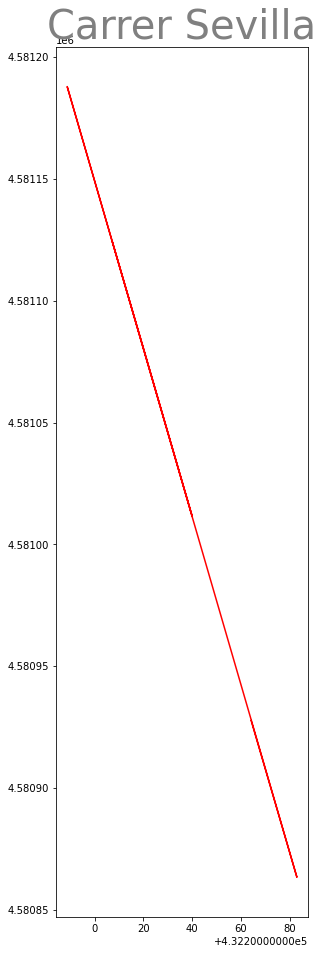

In [26]:
fig, ax = plt.subplots(figsize=(16,16))

fc1 = colorConverter.to_rgba('green', alpha=0.2)

gdf.plot(ax=ax, facecolor = 'none', edgecolor = 'r', marker = '.', aspect = 1) 

plt.title(strtName, fontsize=40, color='grey')
#plt.xlim(426000, 434000)
#plt.ylim(4580000, 4588000)
#plt.axis('equal')

plt.show()

### Game Plan (30/12/21):

Am I able (within my skills) to replicate this process for every name in the NVia_D column. I then need to generate a new GeoDataFrame that has a single row for each named street. There are probably some streets that are interrupted along their path but for now I can't worry about that. Progress is being made - slowly!

[python .unique tool:](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.unique.html?highlight=unique#pandas.unique)
```python
uniqueValues = streets['NVia_D'].unique()
print('Unique elements in column "NVia_D" ')
print(uniqueValues[25:50])
```

[Create Data Frame from List:](https://datascienceparichay.com/article/create-pandas-dataframe-from-numpy-array/) Let's see what happens if I create a ridiculously simplified data frame from the list of unique street names in the street dataframe

In [265]:
uniqueStreets = streets['NVia_D'].unique()
print('Unique elements in column "NVia_D" ')
print(uniqueStreets[0:10])

Unique elements in column "NVia_D" 
['Carrer Pepe Rubianes' 'Carrer Almirall Aixada' 'Carrer Judici' ' '
 'Carrer Drassana' 'Carrer Mar' 'Carrer Sant Elm' 'Carrer Sant Miquel'
 'Carrer Pescadors' 'Carrer Comte de Santa Clara']


In [266]:
uniqueStreets = np.delete(uniqueStreets,3)
#uniqueStreets = np.delete(uniqueStreets,3)
print(uniqueStreets[0:10])

['Carrer Pepe Rubianes' 'Carrer Almirall Aixada' 'Carrer Judici'
 'Carrer Drassana' 'Carrer Mar' 'Carrer Sant Elm' 'Carrer Sant Miquel'
 'Carrer Pescadors' 'Carrer Comte de Santa Clara' 'Carrer Sevilla']


In [267]:
streetDF = gpd.GeoDataFrame(uniqueStreets, columns=['name'])
streetDF['geometry'] = ' '
streetDF

/Users/bruceemerson/opt/anaconda3/envs/my_env/lib/python3.7/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


,name,geometry
0,Carrer Pepe Rubianes,
1,Carrer Almirall Aixada,
2,Carrer Judici,
3,Carrer Drassana,
4,Carrer Mar,
...,...,...
3949,Passatge Marquès de Castellbell,
3950,Carrer Marcel·lí,
3951,Plaça Estatut,
3952,Plaça Pablo Neruda,


In [268]:
streetDF.at[ 0 , 'geometry']= carrerLine
streetDF[20:30]

,name,geometry
20,Carrer Vinaròs,
21,Carrer Alcanar,
22,Carrer Sòria,
23,Carrer Berenguer Mallol,
24,Carrer Doctor Giné i Partagàs,
25,Carrer Salamanca,
26,Carrer Proclamació,
27,Carrer Escuder,
28,Carrer Almirall Churruca,
29,Carrer La Maquinista,


### Error Tracking:

Carrer Marquet is a case in point. It is a very short carrer consisting of 2 points. When I filter individually above it assembles and plots correctly. When I think I've done the same thing below There are many points to the LineString for Carrer Marquet and the path is a mess. I think when I sort this out I'll find at least some portion of my problem.

In [284]:
# trigger to print out some data for debugging
checkNum = 58

for count, name in enumerate (uniqueValues):
#    print('count; ', count)
    thisStreet = streets[streets["NVia_D"] == name]
    geoStreet = gpd.GeoDataFrame(thisStreet, geometry = gpd.points_from_xy(thisStreet.COORD_X,thisStreet.COORD_Y))
    tmpCarrer = []
    for count2, point in enumerate(geoStreet.geometry):
        tmpCarrer += [(point.x, point.y)]
    if (len(tmpCarrer) > 1):
        tmpLine = LineString(tmpCarrer)
    else:
        tmpLine = Point(tmpCarrer)
    if (count == checkNum):
        print('name, tmpCarrer: ', (name, tmpCarrer))
    streetDF.at[ count , 'geometry']= tmpLine
    if (count > 60):
        break


name, tmpCarrer:  ('Carrer Mercè', [(431460.262, 4581278.458), (431491.552, 4581330.329), (431521.376, 4581379.517), (431368.997, 4581123.015), (431393.392, 4581166.487), (431368.357, 4581156.871), (431364.283, 4581185.094), (431389.318, 4581194.71), (431408.351, 4581193.073), (431436.161, 4581239.497), (431421.698, 4581215.172)])


In [281]:
streetDF[55:60]

,name,geometry
55,Plaça Pau Vila,"LINESTRING (431661.662 4581593.332, 431680.151..."
56,Plaça Barceloneta,"LINESTRING (432023.630 4581352.878, 431872.923..."
57,Carrer Mercè,"LINESTRING (432108.464 4581247.867, 432118.716..."
58,Carrer Marquet,"LINESTRING (431460.262 4581278.458, 431491.552..."
59,Carrer Plata,"LINESTRING (431484.204 4581363.582, 431535.221..."


In [24]:
streetDF[58, 'geometry']

NameError: name 'streetDF' is not defined

### Plot what I got...

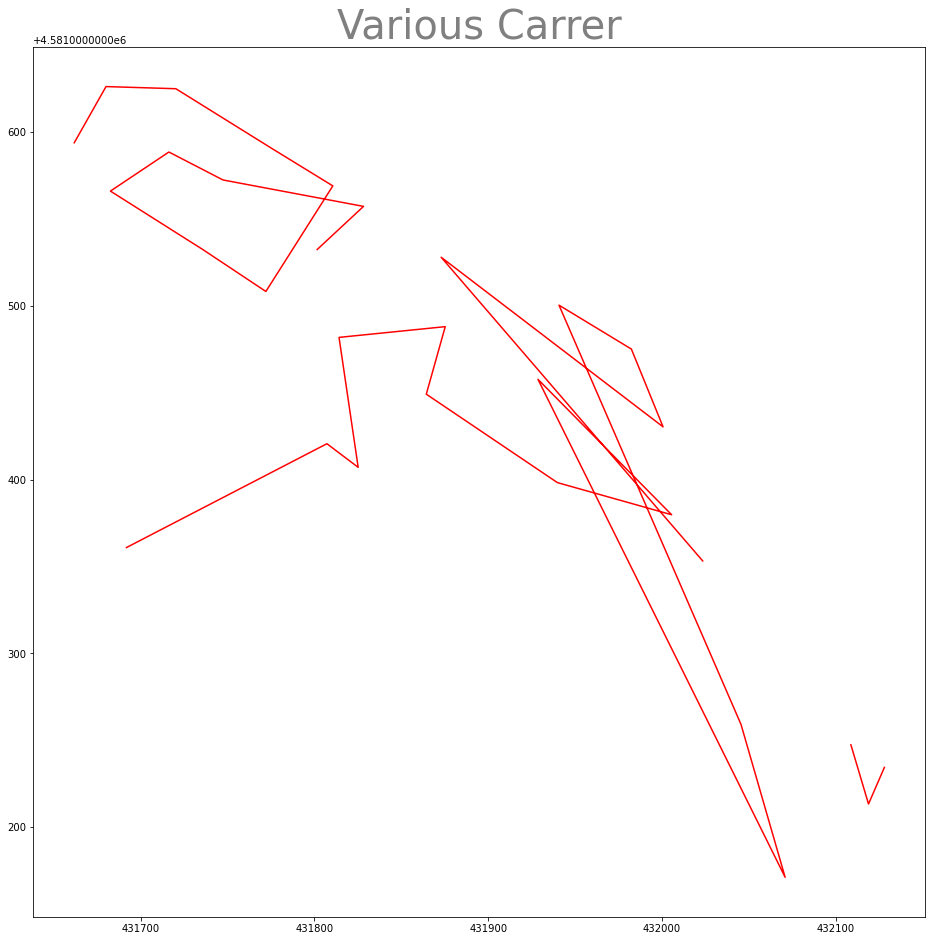

In [238]:
fig3, ax3 = plt.subplots(figsize=(16,16))

fc1 = colorConverter.to_rgba('green', alpha=0.2)

streetDF[55:58].plot(ax=ax3, facecolor = 'none', edgecolor = 'r', marker = '.', aspect = 1) 

plt.title("Various Carrer", fontsize=40, color='grey')
#plt.xlim(426000, 434000)
#plt.ylim(4580000, 4588000)
#plt.axis('equal')

plt.show()